In [269]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import trange
import csv
from pprint import pprint
import seaborn as sns
import pickle
sns.set_theme()

## Importing Graph Data

In [270]:
Data = open('soc-sign-bitcoinotc.csv', "r")
next(Data, None)  # skip the first line
graph_type = nx.DiGraph()
df = pd.read_csv("soc-sign-bitcoinotc.csv")
df = df.sort_values(by = "Timestamp")
# Reducing weights to -1 to 1 range:
df.Weight /= 10
df.Weight = df.Weight - df.Weight.mean() # Setting the mean to zero![Want more negative edges!!]
print(df.head())
split = int(0.1*len(df)) # USing first 10% data for the initial experimentation
train = df.iloc[:split,:]
test = df.iloc[split:,:]
G = nx.from_pandas_edgelist(train,
                            source='Source',
                            target='Target',
                            edge_attr='Weight',
                            create_using=graph_type)

   Source  Target    Weight   Timestamp
0       6       2  0.298797  1289241912
1       6       5  0.098797  1289241942
2       1      15 -0.001203  1289243140
3       4       3  0.598797  1289245277
4      13      16  0.698797  1289254254


In [271]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 817
Number of edges: 3559
Average in degree:   4.3562
Average out degree:   4.3562


In [272]:
list(G.edges(data=True))[:5]

[(6, 2, {'Weight': 0.29879748258035516}),
 (6, 5, {'Weight': 0.09879748258035513}),
 (6, 4, {'Weight': 0.09879748258035513}),
 (6, 7, {'Weight': 0.39879748258035513}),
 (6, 114, {'Weight': 0.09879748258035513})]

In [273]:
G.number_of_nodes()

817

In [274]:
max(G.nodes)

864

## Implementing SignRank Computation

> Reference: https://www.hindawi.com/journals/wcmc/2019/4813717/

In [275]:
class SignRank():
    def __init__(self, G):
        '''
        '''
        self.G = G
        self.n_nodes = G.number_of_nodes()
        self.mx_node = max(G.nodes)
        
        self.pos_edges = None
        self.neg_edges = None
        
        self.pos_probab = None
        self.neg_probab = None
        
        self.emo = 1
        self.iterMax = None
    
    def prepare_walker(self, iterMax):
        '''
        '''
        self.pos_edges = [(e[0], e[1]) for e in G.edges(data=True) if e[2]['Weight'] > 0]
        self.neg_edges = [(e[0], e[1]) for e in G.edges(data=True) if e[2]['Weight'] < 0]
        
        self.pos_probab = np.ones((2, self.mx_node+1))
        self.pos_probab /= (2*self.n_nodes)
        self.neg_probab = np.ones((2, self.mx_node+1))
        self.neg_probab /= (2*self.n_nodes)
        
        present = sorted(list(G.nodes))
        for i in range(self.mx_node+1):
            if i in present:
                pass
            else:
                self.pos_probab[:,i] = 0
                self.neg_probab[:,i] = 0
        
        self.emo = 1
        self.iterMax = iterMax
        
    def computeSR(self, iterMax, lam, alph):
        '''
        lam: tiredness probability
        alph: hopping probability
        '''
        self.prepare_walker(iterMax)
        
        for iter in range(1, iterMax+1):
            print('[Logs] Iter: ', iter)
            for pe in self.pos_edges:
                i = pe[0]
                j = pe[1]
                self.pos_probab[1][j] = self.pos_probab[0][i]/(self.G.out_degree(i))
                self.neg_probab[1][j] = self.neg_probab[0][i]/(self.G.out_degree(i) * lam)
                
            for ne in self.neg_edges:
                i = ne[0]
                j = ne[1]
                self.pos_probab[1][j] = self.pos_probab[0][i]/(self.G.out_degree(i) * lam)
                self.neg_probab[1][j] = self.neg_probab[0][j]/(self.G.out_degree(i))
                
            nsum = (np.sum(self.neg_probab[0])*lam)/(self.n_nodes * 2)
            
            self.pos_probab[1] += nsum
            self.pos_probab[1] *= (alph * (1-alph))/(2 * self.n_nodes)
            
            self.neg_probab[1] += nsum
            self.neg_probab[1] *= (alph * (1-alph))/(2 * self.n_nodes)
            
            err = abs(np.sum(self.pos_probab[1]) + np.sum(self.neg_probab[1]) - np.sum(self.pos_probab[0]) - np.sum(self.neg_probab[0]))
            
            print("Err: ", err)
            
#             if err < self.n_nodes * tol:
#                 return self.pos_probab[1], self.neg_probab[0]
            
            self.pos_probab[0] = self.pos_probab[1]
            self.neg_probab[0] = self.neg_probab[1]
        
        return self.pos_probab[1], self.neg_probab[1]
            

In [276]:
sr = SignRank(G)

In [277]:
pos_probabs, neg_probabs = sr.computeSR(4, 0.1, 0.1)

[Logs] Iter:  1
Err:  0.9999245028085193
[Logs] Iter:  2
Err:  7.548486040876715e-05
[Logs] Iter:  3
Err:  1.2328008250309152e-08
[Logs] Iter:  4
Err:  3.062612106615041e-12


In [278]:
reputation = pos_probabs/neg_probabs

In [279]:
node_wise = {}
reputation_list = []
for node in G.nodes:
    node_wise[node] = reputation[node]
    reputation_list.append(reputation[node])

In [280]:
reputation_tups_sorted = sorted(node_wise.items(), key=lambda item: item[1], reverse=True)
sorted_dict = {k: v for k, v in reputation_tups_sorted}

# print(sorted_dict)
print("Top 15 reputed users and their reputation: ")
pprint(reputation_tups_sorted[:15])
print()
print("Bottom 15 reputed users and their reputation: ")
pprint(reputation_tups_sorted[-15:])

Top 15 reputed users and their reputation: 
[(497, 16126.468388962288),
 (565, 16126.468388962288),
 (679, 16126.468388962288),
 (685, 16126.468388962288),
 (699, 16126.468388962288),
 (719, 16126.468388962288),
 (723, 16126.468388962288),
 (752, 16126.468388962288),
 (824, 16126.468388962288),
 (827, 16126.468388962288),
 (662, 11884.707931328652),
 (708, 11884.707931328652),
 (710, 11884.707931328652),
 (737, 11884.707931328652),
 (141, 8956.16184285248)]

Bottom 15 reputed users and their reputation: 
[(295, 0.8821698545678622),
 (637, 0.7633938930551337),
 (88, 0.733760772334296),
 (666, 0.632803380022752),
 (860, 0.632803380022752),
 (861, 0.632803380022752),
 (588, 0.47005906357112415),
 (858, 0.08730832131665725),
 (733, 0.0004145672017666705),
 (778, 0.0003973608686047534),
 (755, 0.0002466420237749101),
 (839, 0.0002466420237749101),
 (760, 0.00020284502454154891),
 (834, 0.00018048848230255797),
 (835, 0.00018048848230255797)]


In [281]:
# For plotting the reputation of users
pos = nx.kamada_kawai_layout(G)

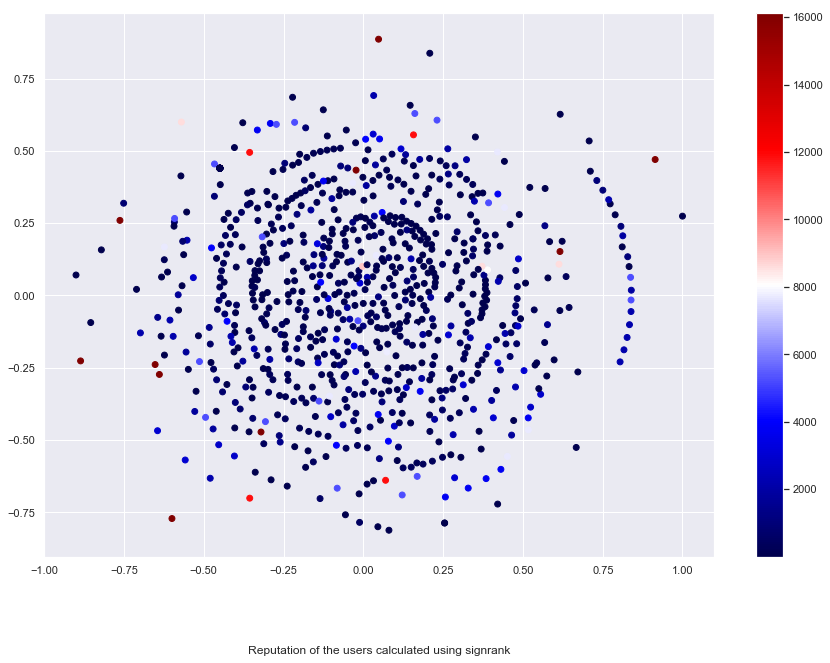

In [282]:
Xs,Ys =[], []
for x,y in list(pos.values()):
    Xs.append(x)
    Ys.append(y)
plt.figure(figsize=(15,10))
plt.scatter(Xs,Ys, c=list(reputation_list), s=35, cmap = plt.cm.get_cmap('seismic'))
plt.colorbar()
plt.title("Reputation of the users calculated using signrank", y=-0.19)
plt.savefig('signrank_plot.png')
plt.show()

In [286]:
file = open('goodness_values.pickle', 'rb')
goodness_dict = pickle.load(file)
file.close()

In [287]:
goodness_tups_sorted = sorted(goodness_dict.items(), key=lambda item: item[1], reverse=True)
sorted_goodness = {k: v for k, v in goodness_tups_sorted}

In [288]:
goodness_ranks = {}
signrank_ranks = {}

for i in range(len(goodness_tups_sorted)):
    goodness_ranks[goodness_tups_sorted[i][0]] = i
    signrank_ranks[reputation_tups_sorted[i][0]] = i

In [289]:
grank_s = pd.Series(goodness_ranks)

In [290]:
srank_s = pd.Series(signrank_ranks)

In [291]:
n = len(srank_s)

In [292]:
diff = 6*pow((grank_s - srank_s),2)/(n*(n*n-1))

d:\python\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


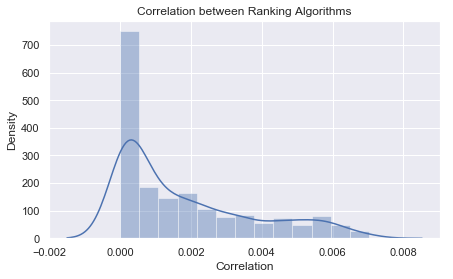

In [299]:
plt.figure(figsize=(7,4))
sns.distplot(diff)
plt.title("Correlation between Ranking Algorithms")
plt.xlabel("Correlation")
plt.ylabel("Density")
plt.savefig("ranks_corr.png")
plt.show()